# Detecting Apriltags

Kevin J. Walchko

---

In [2]:
# reload library
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import cv2
import cv2.aruco as aruco
from matplotlib import pyplot as plt
# from pathlib import Path

import opencv_camera
print("OpenCV Camera:", opencv_camera.__version__)

from math import asin, atan2,pi

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

def scale(im, s=1.0):
    (h,w) = im.shape[:2]
    return cv2.resize(im, (int(s*w), int(s*h),), interpolation=cv2.INTER_AREA)

deg = u"\xb0" # unicode degree symbol

OpenCV Camera: 0.11.0


In [4]:
from opencv_camera import ApriltagMarker
from collections import namedtuple

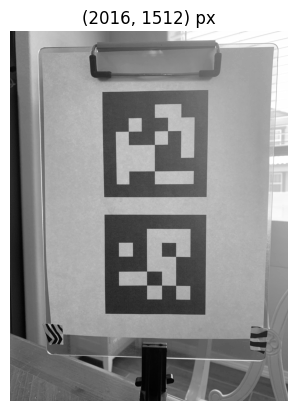

In [3]:
img = cv2.imread("IMG_0018.png",0)

img = scale(img, 0.5)
plt.imshow(img, cmap="gray");
plt.axis("off")
plt.title(f"{img.shape} px");

In [4]:
def drawDetectedMarkers(image, corners, ids, size=1, color=None):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
    if len(corners) == 0:
        return image
        
    # if len(corners) > 0:
    # cv2.aruco.drawDetectedMarkers(image, corners)

    # flatten the ArUco IDs list
    ids = ids.flatten()
    # loop over the detected ArUCo corners
    # for (markerCorner, markerID) in zip([corners], ids):
    markerCorner, markerID = corners, ids

    # extract the marker corners (which are always returned in
    # top-left, top-right, bottom-right, and bottom-left order)
    if markerCorner.shape != (4,2):
        corners = markerCorner.reshape((4, 2))
    (topLeft, topRight, bottomRight, bottomLeft) = corners
    # convert each of the (x, y)-coordinate pairs to integers
    topRight = (int(topRight[0]), int(topRight[1]))
    bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
    bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
    topLeft = (int(topLeft[0]), int(topLeft[1]))

    thick = abs(topLeft[0] - bottomRight[0])//30
    cv2.line(image, topLeft, topRight, (0, 255, 0), thick)
    cv2.line(image, topRight, bottomRight, (0, 255, 0), thick)
    cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), thick)
    cv2.line(image, bottomLeft, topLeft, (0, 255, 0), thick)
    # compute and draw the center (x, y)-coordinates of the ArUco
    # marker
    dia = abs(topLeft[0] - bottomRight[0])//20
    cX = int((topLeft[0] + bottomRight[0]) / 2.0)
    cY = int((topLeft[1] + bottomRight[1]) / 2.0)
    cv2.circle(image, (cX, cY), dia, (255, 0, 255), -1)

    a = (topLeft[0]+dia,topLeft[1]+dia)
    b = (topLeft[0]-dia,topLeft[1]-dia)
    cv2.rectangle(image, a,b, (0, 0, 200), thick)

    # draw the ArUco marker ID on the image
    if color is None:
        color = (100, 100, 100)
    cv2.putText(
        image, str(markerID),
        (topLeft[0] + 2*dia, topLeft[1] - 2*dia), 
        cv2.FONT_HERSHEY_SIMPLEX,
        size, color, size)
    # print("[Inference] ArUco marker ID: {}".format(markerID))
    return image

In [5]:
# def findMarkers(imgs, flag):
#     if not isinstance(imgs, list):
#         imgs = [imgs]
        
#     h,w = imgs[0].shape[:2]
#     f = max(h,w)  # focal length is a function of image size in pixels
#     K = np.array([
#         [f,0,w/2],
#         [0,f,h/2],
#         [0,0,1]
#     ])
#     dist = np.array([[0.0,0,0,0,0]])
    
#     pose = {} #{frame: {id: rpy}}
#     rframes = []

#     for num, gray in enumerate(imgs):
#         if len(gray.shape) != 2:
#             gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
            
#         corners, ids, rejectedImgPts = aruco.detectMarkers(
#             gray,
#             aruco.Dictionary_get(flag), 
#             parameters=aruco.DetectorParameters_create(),
#             # cameraMatrix=K,
#             # distCoeff=dist
#         )
        
#         frame = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

#         if len(corners) > 0:
#             ids = ids.ravel()
#             drawDetectedMarkers(frame, corners,ids) 
#             for i, id in enumerate(ids):
#                 rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(
#                     corners[i],
#                     0.02,
#                     K,
#                     dist)

#                 R = cv2.Rodrigues(rvec)[0]
#                 t = tvec.ravel()
#                 # print(ids[i], "-"*30)
#                 roll = atan2(R[2,1], R[2,2])*180/pi
#                 pitch = -asin(R[2,0])*180/pi
#                 yaw = atan2(R[1,0], R[0,0])*180/pi
#                 # print(f"  RPY: {roll:0.1f}, {pitch:0.1f}, {yaw: 0.1f} degrees")
#                 # print(f"  T: {t}")

#                 # cv2.aruco.drawDetectedMarkers(frame, corners) 
#                 # cv2.aruco.drawAxis(frame, K, dist, rvec, tvec, 0.01)
#                 cv2.drawFrameAxes(frame, K, dist, rvec, tvec, length=0.01, thickness=20)
#                 # print(id,roll, pitch, yaw)
#                 pose[num] = {id: (roll, pitch, yaw,)}
#         rframes.append(frame)

#     return pose, rframes

In [6]:
# rpys, rframes = findMarkers(img, aruco.DICT_APRILTAG_36h11)

In [7]:
# plt.imshow(rframes[0])
# plt.axis("off");

In [9]:
# for num, keypt in rpys.items():
#     print(f"Frame[{num}]")
#     for ident, rpy in keypt.items():
#         print(f"  ID: {ident}, roll: {rpy[0]:.1f}{deg}, pitch: {rpy[1]:.1f}{deg}, yaw: {rpy[2]:.1f}{deg}")

In [39]:
corners, ids, rejectedImgPts = aruco.detectMarkers(
    img,
    aruco.Dictionary_get(aruco.DICT_APRILTAG_36h11), 
    parameters=aruco.DetectorParameters_create(),
)

In [40]:
Tag = namedtuple("Tag","tag_id corners")

tags = [Tag(ids[0][0], np.array(corners[0][0]))]

at = ApriltagMarker()
cimg = at.draw(img, tags)

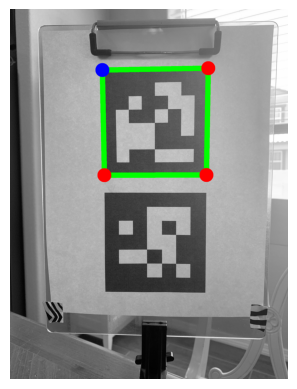

In [12]:
plt.imshow(cimg)
plt.axis("off");

In [13]:
print(tags)

[Tag(tag_id=3, corners=array([[ 502.,  332.],
       [1078.,  322.],
       [1068.,  904.],
       [ 513.,  905.]], dtype=float32))]


In [36]:
def getTagPose(tags, K, dist):
    corners = [t.corners for t in tags]
    ids = [t.tag_id for t in tags]
    
    rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(
        corners, #FIXME: remove for loop
        0.02,
        K,
        dist)

    R = cv2.Rodrigues(rvec)[0]
    t = tvec.ravel()
    
    return R, t


def r2euler(R, degrees=False):
    roll = atan2(R[2,1], R[2,2])
    pitch = -asin(R[2,0])
    yaw = atan2(R[1,0], R[0,0])
    
    if degrees is True:
        r2d = 180 / pi
        roll *= r2d
        pitch *= r2d
        yaw *= r2d
    
    return roll, pitch, yaw

    
def drawMarkerOrientations(img, tags, K=None, dist=None):
    if len(tags) == 0:
        return img
        
    if len(img.shape) != 3:
        frame = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    else: frame = img.copy()
    
    if K is None:
        h,w = img.shape[:2]
        f = max(h,w)  # focal length is a function of image size in pixels
        K = np.array([
            [f,0,w/2],
            [0,f,h/2],
            [0,0,1]
        ])
        
    if dist is None:
        dist = np.array([[0.0,0,0,0,0]])
        
    # for tag in tags:
    #     drawDetectedMarkers(frame, tag.corners, tag.tag_id) 
        
    rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(
        corners, #FIXME: remove for loop
        0.02,
        K,
        dist)

    # these aren't the best, which is why I made my own
    # cv2.aruco.drawDetectedMarkers(frame, corners, ids=ids, borderColor=(0,100,200))
    # cv2.aruco.drawAxis(frame, K, dist, rvec, tvec, 0.01)
    cv2.drawFrameAxes(frame, K, dist, rvec, tvec, length=0.01, thickness=20)

    return frame

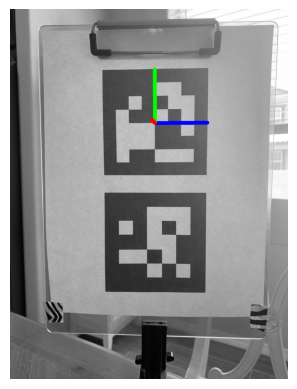

In [37]:
im = drawMarkerOrientations(img.copy(), tags)
plt.imshow(im)
plt.axis("off");

In [16]:

h,w = img.shape[:2]
f = max(h,w)  # focal length is a function of image size in pixels
K = np.array([
    [f,0,w/2],
    [0,f,h/2],
    [0,0,1]
])

dist = np.array([[0.0,0,0,0,0]])
        
R, t = getTagPose(tags, K, dist)

print(R)
print(t)

print( r2euler(R, degrees=True) )

[[ 0.998 -0.005 -0.062]
 [ 0.004 -0.991  0.134]
 [-0.062 -0.134 -0.989]]
[ 0.001 -0.014  0.071]
(-172.28645622837755, 3.5813376170113407, 0.22201566374502635)


In [ ]:
# b=cv2.aruco.GridBoard()
# b.draw((4,4))

In [131]:
help(b.draw)

Help on built-in function draw:

draw(...) method of cv2.aruco.GridBoard instance
    draw(outSize[, img[, marginSize[, borderBits]]]) -> img
    .   * @brief Draw a GridBoard
    .        *
    .        * @param outSize size of the output image in pixels.
    .        * @param img output image with the board. The size of this image will be outSize
    .        * and the board will be on the center, keeping the board proportions.
    .        * @param marginSize minimum margins (in pixels) of the board in the output image
    .        * @param borderBits width of the marker borders.
    .        *
    .        * This function return the image of the GridBoard, ready to be printed.



In [21]:
help(cv2.aruco.drawDetectedMarkers)

Help on built-in function drawDetectedMarkers:

drawDetectedMarkers(...)
    drawDetectedMarkers(image, corners[, ids[, borderColor]]) -> image
    .   * @brief Draw detected markers in image
    .    *
    .    * @param image input/output image. It must have 1 or 3 channels. The number of channels is not
    .    * altered.
    .    * @param corners positions of marker corners on input image.
    .    * (e.g std::vector<std::vector<cv::Point2f> > ). For N detected markers, the dimensions of
    .    * this array should be Nx4. The order of the corners should be clockwise.
    .    * @param ids vector of identifiers for markers in markersCorners .
    .    * Optional, if not provided, ids are not painted.
    .    * @param borderColor color of marker borders. Rest of colors (text color and first corner color)
    .    * are calculated based on this one to improve visualization.
    .    *
    .    * Given an array of detected marker corners and its corresponding ids, this functions dra

## Drawing Tags

You can create a dictionary and draw individual tags with it.

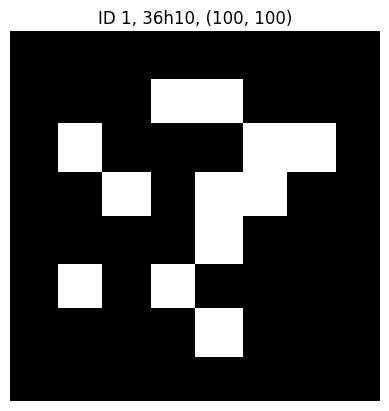

In [52]:
a = aruco.Dictionary_get(aruco.DICT_APRILTAG_36h10)

# ID 1, image size is 100x100 px
m = a.drawMarker(1,100)

plt.imshow(m, cmap="gray")
plt.axis("off")
plt.title(f"ID 1, 36h10, {m.shape}");